# Introducción, objetivos y contenido
====================================================================================================================================

Este trabajo corresponde a la fase de EDA (Exploratory data analysis) del segundo proyecto individual para el curso de DAta Science de Soy Henry. 

El objetivo de esta fase es obtener una comprensión del contenido de los datasets limpios, así como investigar las relaciones entre variables.

Contenidos:
* Importación de librerías y carga de datos
* Preprocesamiento de datos
    * Verificación de tipo de datos
    * Verificación de duplicados
    * Verificación de nulos
* Análisis de datos 
    * Estadística descriptiva
    * Serie de tiempo, tendencias y estacionalidad
    * Relación entre tipos de eventos    
    * Localizaciones
    * Tipos de víctimas
* Conclusiones

# Importación de librerías y carga de datos
====================================================================================================================================

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from math import factorial
from scipy import stats as st

import pyproj

In [2]:
dfh = pd.read_excel('homicidios.xlsx', sheet_name='HECHOS') # homicidios
dfl = pd.read_excel('lesiones.xlsx', sheet_name='HECHOS') # lesiones

# Preprocesamiento de datasets
====================================================================================================================================

En los siguientes análisis, realizaremos:
* Verificación de tipos de datos: en caso de que un campo tenga formato que no se condiga con los datos que representa, se modificará el tipo de datos
* Verificación de duplicados: se eliminarán registros duplicados
* Verificación de nulos: hay tres opciones:
    * Eliminación de registros con valores nulos: se dá en caso de que el registro represente un posible daño para cálculos ulteriores
    * Conservar los registros con valores nulos: en caso de que un campo tenga un valor nulo y ese campo no sea necesario posteriormente, conservar el registro es preferible para evitar pérdida en la calidad de los cálculos posteriores
    * Conservar los registros con valores nulos, reemplazando el valor nulo o faltante: se dá en caso de que el valor faltante sea necesario y que además sea posible reemplazarlo, ya sea buscando patrones de comportamiento o a través de búsquedas en datasets externos

## Dataset HOMICIDIOS

In [3]:
dfh.sample(2)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
332,2018-0058,1,2018-06-03,2018,6,3,06:30:00,6,Cordoba Av. y Thames,AVENIDA,...,NaN,THAMES,CORDOBA AV. y THAMES,15,Point (102567.54814228 104264.87527568),-58.43531242,-34.59082159,MOTO-AUTO,MOTO,AUTO
355,2018-0081,1,2018-07-29,2018,7,29,06:30:00,6,Castañares Av. y Rivera Indarte Av.,AVENIDA,...,NaN,RIVERA INDARTE AV.,CASTAÃ‘ARES AV. y RIVERA INDARTE AV.,7,Point (101453.89687005 98180.39027169),-58.44744156,-34.64567171,MULTIPLE,PEATON,MULTIPLE


In [4]:
# Corrección de nombres de campos
dfh.columns = dfh.columns.str.lower()
dfh.columns = dfh.columns.str.replace(' ', '_')
dfh.columns = dfh.columns.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Transformación de fecha y creación de campos auxiliares de fecha
dfh['fecha'] = pd.to_datetime(dfh['fecha'])
dfh['dia_semana'] = dfh['fecha'].dt.dayofweek
dfh['hh'] = pd.to_numeric(dfh['hh'], errors='coerce')
dfh['period'] = dfh['fecha'].dt.strftime('%y%m')

# Cambio de nombre
dfh['calle_tipo'] = dfh['tipo_de_calle']

# Campo auxiliar
dfh['evento_tipo'] = "muerte"

# Transformación de coordenadas
dfh['pos_x'] = pd.to_numeric(dfh['pos_x'], errors='coerce')
dfh['pos_y'] = pd.to_numeric(dfh['pos_y'], errors='coerce')

# Agregar latitud y longitud
import pandas as pd
from pyproj import Transformer
transformador = Transformer.from_crs("epsg:32610", "epsg:4326")  # UTM Zone 10N a WGS84 # Definir el transformador de coordenadas

def xy_a_lat_long(x, y):                                        # Función para convertir coordenadas XY a latitud y longitud
    longitud, latitud = transformador.transform(x, y)
    return longitud, latitud
# Aplicar la función a cada fila del DataFrame y crear nuevas columnas de longitud y latitud
dfh[['longitud', 'latitud']] = dfh.apply(lambda row: pd.Series(xy_a_lat_long(row['pos_x'], row['pos_y'])), axis=1)

In [5]:
dfh.head(2)

,id,n_victimas,fecha,aaaa,mm,dd,hora,hh,lugar_del_hecho,tipo_de_calle,...,pos_y,participantes,victima,acusado,dia_semana,period,calle_tipo,evento_tipo,longitud,latitud
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4.0,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,-34.687570,MOTO-AUTO,MOTO,AUTO,4,1601,AVENIDA,muerte,-0.000313,-127.489268
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1.0,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,5,1601,GRAL PAZ,muerte,-0.000313,-127.489268


In [6]:
# Verificación de duplicados
dfh.duplicated().sum()
# No se observan duplicados

0

In [7]:
# Verificación de nulos
dfh.isnull().sum()

id                         0
n_victimas                 0
fecha                      0
aaaa                       0
mm                         0
dd                         0
hora                       0
hh                         1
lugar_del_hecho            0
tipo_de_calle              0
calle                      1
altura                   567
cruce                    171
direccion_normalizada      8
comuna                     0
xy_(caba)                  0
pos_x                     12
pos_y                     12
participantes              0
victima                    0
acusado                    0
dia_semana                 0
period                     0
calle_tipo                 0
evento_tipo                0
longitud                  12
latitud                   12
dtype: int64

In [8]:
# Revisar los valores nulos del campo "hh"
dfh_filt1 = dfh[dfh['hh'].isnull()]
dfh_filt1
# Conservaremos este registro ya que sólo le falta un valor

,id,n_victimas,fecha,aaaa,mm,dd,hora,hh,lugar_del_hecho,tipo_de_calle,...,pos_y,participantes,victima,acusado,dia_semana,period,calle_tipo,evento_tipo,longitud,latitud
518,2019-0103,1,2019-12-18,2019,12,18,SD,NaN,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,...,-34.594716,MOTO-MOTO,MOTO,MOTO,2,1912,GRAL PAZ,muerte,-0.000312,-127.489268


In [9]:
# Revisar los valores nulos del campo "direccion_normalizada"
dfh_filt2 = dfh[dfh['direccion_normalizada'].isnull()]
dfh_filt2
# Conservaremos estos registros ya que si bien tienen valores nulos en este campo, tienen información valiosa en los otros campos

,id,n_victimas,fecha,aaaa,mm,dd,hora,hh,lugar_del_hecho,tipo_de_calle,...,pos_y,participantes,victima,acusado,dia_semana,period,calle_tipo,evento_tipo,longitud,latitud
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20.0,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,NaN,MOTO-SD,MOTO,SD,2,1604,AUTOPISTA,muerte,NaN,NaN
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0.0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,NaN,MOTO-CARGAS,MOTO,CARGAS,1,1610,AUTOPISTA,muerte,NaN,NaN
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20.0,SD,CALLE,...,NaN,PEATON-SD,PEATON,SD,4,1611,CALLE,muerte,NaN,NaN
180,2017-0050,2,2017-04-28,2017,4,28,11:08:08,11.0,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,...,NaN,MOTO-CARGAS,MOTO,CARGAS,4,1704,AUTOPISTA,muerte,NaN,NaN
181,2017-0051,1,2017-05-01,2017,5,1,03:47:47,3.0,AU DELLEPIANE 2400,AUTOPISTA,...,NaN,AUTO-AUTO,AUTO,AUTO,0,1705,AUTOPISTA,muerte,NaN,NaN
313,2018-0039,1,2018-04-21,2018,4,21,22:15:00,22.0,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,...,NaN,PEATON-AUTO,PEATON,AUTO,5,1804,AUTOPISTA,muerte,NaN,NaN
546,2020-0026,1,2020-05-17,2020,5,17,06:40:00,6.0,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,...,NaN,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO,6,2005,AUTOPISTA,muerte,NaN,NaN
621,2021-0023,1,2021-03-01,2021,3,1,09:20:00,9.0,"AU BUENOS AIRES LA PLATA KM 4,5",AUTOPISTA,...,NaN,MOTO-CARGAS,MOTO,CARGAS,0,2103,AUTOPISTA,muerte,NaN,NaN


In [10]:
# Revisar los valores nulos del campo "pos_x" y "pos_y"
dfh_filt3 = dfh[dfh['pos_x'].isnull()]
dfh_filt3
# Los valores no pueden calcularse ya que no cuentan con el input para su cálculo; optaremos por conservar estos registros

,id,n_victimas,fecha,aaaa,mm,dd,hora,hh,lugar_del_hecho,tipo_de_calle,...,pos_y,participantes,victima,acusado,dia_semana,period,calle_tipo,evento_tipo,longitud,latitud
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20.0,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,NaN,MOTO-SD,MOTO,SD,2,1604,AUTOPISTA,muerte,NaN,NaN
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0.0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,NaN,MOTO-CARGAS,MOTO,CARGAS,1,1610,AUTOPISTA,muerte,NaN,NaN
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20.0,SD,CALLE,...,NaN,PEATON-SD,PEATON,SD,4,1611,CALLE,muerte,NaN,NaN
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0.0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,NaN,SD-SD,SD,SD,1,1612,AUTOPISTA,muerte,NaN,NaN
176,2017-0042,1,2017-04-10,2017,4,10,09:00:00,9.0,AV. LEOPOLDO LUGONES PKM 6900,GRAL PAZ,...,NaN,MOTO-CARGAS,MOTO,CARGAS,0,1704,GRAL PAZ,muerte,NaN,NaN
180,2017-0050,2,2017-04-28,2017,4,28,11:08:08,11.0,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,...,NaN,MOTO-CARGAS,MOTO,CARGAS,4,1704,AUTOPISTA,muerte,NaN,NaN
181,2017-0051,1,2017-05-01,2017,5,1,03:47:47,3.0,AU DELLEPIANE 2400,AUTOPISTA,...,NaN,AUTO-AUTO,AUTO,AUTO,0,1705,AUTOPISTA,muerte,NaN,NaN
256,2017-0140,1,2017-11-19,2017,11,19,23:22:17,23.0,AU ARTURO FRONDIZI PKM 3100,AUTOPISTA,...,NaN,MOTO-PASAJEROS,MOTO,PASAJEROS,6,1711,AUTOPISTA,muerte,NaN,NaN
313,2018-0039,1,2018-04-21,2018,4,21,22:15:00,22.0,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,...,NaN,PEATON-AUTO,PEATON,AUTO,5,1804,AUTOPISTA,muerte,NaN,NaN
546,2020-0026,1,2020-05-17,2020,5,17,06:40:00,6.0,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,...,NaN,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO,6,2005,AUTOPISTA,muerte,NaN,NaN


In [11]:
# Eliminar los registros cuya comuna presenta el valor cero
dfh = dfh.drop(dfh[dfh['comuna'] == 0].index)

Tratamiento de valores nulos

* Valores nulos de "hh": conservaremos este registro ya que le falta un solo valor
* Valores nulos de "direccion_normalizada": estos valores no se usarán por lo cual conservaremos estos registros
* Valores nulos de "pos_x" y "pos_y": a efectos del EDA estos valores no serán necesarios
* Valores nulos de "comuna": eliminados pues más adelante afectará a un cálculo

In [12]:
# Dataset depurado
dfh = dfh[['id', 'n_victimas', 'fecha', 'aaaa', 'mm','dd', 'dia_semana', 'hh', 'period',
           'lugar_del_hecho', 'direccion_normalizada', 'calle_tipo', 'comuna', 'pos_x', 'pos_y', 'latitud', 'longitud', 
            'participantes', 'victima', 'acusado', 'evento_tipo' ]]
dfh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     694 non-null    object        
 1   n_victimas             694 non-null    int64         
 2   fecha                  694 non-null    datetime64[ns]
 3   aaaa                   694 non-null    int64         
 4   mm                     694 non-null    int64         
 5   dd                     694 non-null    int64         
 6   dia_semana             694 non-null    int32         
 7   hh                     693 non-null    float64       
 8   period                 694 non-null    object        
 9   lugar_del_hecho        694 non-null    object        
 10  direccion_normalizada  687 non-null    object        
 11  calle_tipo             694 non-null    object        
 12  comuna                 694 non-null    int64         
 13  pos_x     

## Dataset LESIONES

In [13]:
dfl.head(2)

,id,n_victimas,aaaa,mm,dd,fecha,hora,franja_hora,direccion_normalizada,comuna,...,latutid,victima,acusado,participantes,moto,auto,transporte_publico,camion,ciclista,gravedad
0,LC-2019-0000179,1,2019,1,1,2019-01-01 00:00:00,09:00:00,9,SD,14,...,-34.559658,CICLISTA,SD,CICLISTA-SD,SD,SD,SD,SD,x,SD
1,LC-2019-0000053,1,2019,1,1,2019-01-01 00:00:00,01:55:00,1,SD,8,...,-34.669125,AUTO,SD,AUTO-SD,SD,x,SD,SD,SD,SD


In [14]:
dfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23785 entries, 0 to 23784
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     23785 non-null  object 
 1   n_victimas             23785 non-null  int64  
 2   aaaa                   23785 non-null  int64  
 3   mm                     23785 non-null  int64  
 4   dd                     23785 non-null  int64  
 5   fecha                  23785 non-null  object 
 6   hora                   23785 non-null  object 
 7   franja_hora            23780 non-null  object 
 8   direccion_normalizada  23732 non-null  object 
 9   comuna                 23616 non-null  object 
 10  tipo_calle             23785 non-null  object 
 11  otra_direccion         23785 non-null  object 
 12  calle                  12867 non-null  object 
 13  altura                 12771 non-null  float64
 14  cruce                  9407 non-null   object 
 15  ge

In [15]:
# Transformación de datos y adecuación de campos
dfl['fecha'] = pd.to_datetime(dfl['fecha'])
dfl['dia_semana'] = dfl['fecha'].dt.dayofweek
dfl['hh'] = pd.to_numeric(dfl['franja_hora'], errors='coerce')
dfl['period'] = dfl['fecha'].dt.strftime('%y%m')


dfl['lugar_del_hecho'] =  dfl['direccion_normalizada']
dfl['calle_tipo'] = dfl['tipo_calle']
dfl['comuna'] = pd.to_numeric(dfl['comuna'], errors='coerce')

dfl['latitud'] = dfl['latutid']
dfl['latitud'] = pd.to_numeric(dfl['latitud'], errors='coerce')
dfl['longitud'] = pd.to_numeric(dfl['longitud'], errors='coerce')
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
dfl['pos_x'], dfl['pos_y'] = transformer.transform(dfl['longitud'].values, dfl['latitud'].values)

dfl['participantes'] = dfl['victima'] + "-" + dfl['acusado']
dfl['evento_tipo'] = "lesión"

# Adecuación de valores nulos
dfl.replace('SD', pd.NA, inplace=True)

dfl = dfl[['id', 'n_victimas', 'fecha', 'aaaa', 'mm','dd', 'dia_semana', 'hh', 'period',
           'lugar_del_hecho', 'direccion_normalizada', 'calle_tipo', 'comuna', 'pos_x', 'pos_y', 'latitud', 'longitud',
            'participantes', 'victima', 'acusado', 'evento_tipo' ]]
dfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23785 entries, 0 to 23784
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     23785 non-null  object        
 1   n_victimas             23785 non-null  int64         
 2   fecha                  23785 non-null  datetime64[ns]
 3   aaaa                   23785 non-null  int64         
 4   mm                     23785 non-null  int64         
 5   dd                     23785 non-null  int64         
 6   dia_semana             23785 non-null  int32         
 7   hh                     23776 non-null  float64       
 8   period                 23785 non-null  object        
 9   lugar_del_hecho        12917 non-null  object        
 10  direccion_normalizada  12917 non-null  object        
 11  calle_tipo             12740 non-null  object        
 12  comuna                 22328 non-null  float64       
 13  p

In [16]:
dfl.head(2)

,id,n_victimas,fecha,aaaa,mm,dd,dia_semana,hh,period,lugar_del_hecho,...,calle_tipo,comuna,pos_x,pos_y,latitud,longitud,participantes,victima,acusado,evento_tipo
0,LC-2019-0000179,1,2019-01-01,2019,1,1,1,9.0,1901,<NA>,...,<NA>,14.0,-6.502050e+06,-4.104200e+06,-34.559658,-58.408911,CICLISTA-SD,CICLISTA,<NA>,lesión
1,LC-2019-0000053,1,2019-01-01,2019,1,1,1,1.0,1901,<NA>,...,<NA>,8.0,-6.505902e+06,-4.119007e+06,-34.669125,-58.443510,AUTO-SD,AUTO,<NA>,lesión


In [17]:
# Verificación de duplicados
dfl.duplicated().sum()
# No se observan duplicado

0

In [18]:
# Verificación de nulos
dfl.isnull().sum()
# Conservaremos los registros con valores nulos

id                           0
n_victimas                   0
fecha                        0
aaaa                         0
mm                           0
dd                           0
dia_semana                   0
hh                           9
period                       0
lugar_del_hecho          10868
direccion_normalizada    10868
calle_tipo               11045
comuna                    1457
pos_x                     1471
pos_y                     1471
latitud                   1471
longitud                  1471
participantes                0
victima                  10733
acusado                  15288
evento_tipo                  0
dtype: int64

In [19]:
dfl[dfl['acusado'].isna()].sample(10)

,id,n_victimas,fecha,aaaa,mm,dd,dia_semana,hh,period,lugar_del_hecho,...,calle_tipo,comuna,pos_x,pos_y,latitud,longitud,participantes,victima,acusado,evento_tipo
15396,LC-2020-0638557,1,2020-12-01,2020,12,1,1,14.0,2012,AVELLANEDA AV. y BAHIA BLANCA,...,AVENIDA,10.0,-6.510221e+06,-4.113599e+06,-34.629157,-58.482311,SD-SD,<NA>,<NA>,lesión
865,LC-2019-0077333,1,2019-02-06,2019,2,6,2,9.0,1902,<NA>,...,<NA>,12.0,-6.511447e+06,-4.102675e+06,-34.548370,-58.493326,AUTO-SD,AUTO,<NA>,lesión
4321,LC-2019-0328307,1,2019-05-26,2019,5,26,6,20.0,1905,<NA>,...,<NA>,10.0,-6.510404e+06,-4.114086e+06,-34.632759,-58.483955,MOTO-SD,MOTO,<NA>,lesión
5776,LC-2019-0430751,2,2019-07-12,2019,7,12,4,16.0,1907,<NA>,...,<NA>,12.0,-6.512646e+06,-4.108435e+06,-34.590980,-58.504092,SD-SD,<NA>,<NA>,lesión
20931,LC-2021-0420152,1,2021-08-24,2021,8,24,1,19.0,2108,SARANDI y REPUBLICA BOLIVARIANA DE VENEZUELA,...,CALLE,3.0,-6.500460e+06,-4.111703e+06,-34.615144,-58.394629,SD-SD,<NA>,<NA>,lesión
3800,LC-2019-0293645,1,2019-05-11,2019,5,11,5,3.0,1905,<NA>,...,<NA>,7.0,-6.508984e+06,-4.114270e+06,-34.634118,-58.471196,SD-SD,<NA>,<NA>,lesión
2447,LC-2019-0197364,1,2019-03-30,2019,3,30,5,0.0,1903,<NA>,...,<NA>,5.0,-6.504273e+06,-4.111688e+06,-34.615032,-58.428880,SD-SD,<NA>,<NA>,lesión
6029,LC-2019-0449608,1,2019-07-20,2019,7,20,5,12.0,1907,<NA>,...,<NA>,12.0,-6.511456e+06,-4.105288e+06,-34.567708,-58.493407,SD-SD,<NA>,<NA>,lesión
1449,LC-2019-0123339,1,2019-02-26,2019,2,26,1,16.0,1902,<NA>,...,<NA>,3.0,-6.501585e+06,-4.111716e+06,-34.615241,-58.404734,SD-SD,<NA>,<NA>,lesión
16166,LC-2021-0069659,1,2021-02-14,2021,2,14,6,3.0,2102,SAN JUAN AV. y SAN JOSE,...,AVENIDA,1.0,-6.499481e+06,-4.112683e+06,-34.622390,-58.385833,CICLISTA-SD,CICLISTA,<NA>,lesión


Tratamiento de valores nulos

A efectos del EDA aquellos campos que son necesarios y presentan valores nulos, son: "comuna", "victima" y "acusado". Del total de 23785 registros, los campos con valores nulos representan una gran cantidad.
* Valores nulos del campo "comuna": dado que no tienen una dirección asociada, no resulta posible determinar la comuna; optaremos por conservar estos registros
* Valores nulos de los campos "acusado" y "victima": dado que no es posible estimar estos valores y representan una gran cantidad de registros, optaremos por conservarlos

In [20]:
# Exportqar dataset de eventos
# eventos = pd.concat([dfh, dfl])
# eventos.to_excel("eventos.xlsx", index=False)

# Análisis de datos
====================================================================================================================================

## Estadística Descriptiva
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Para una primer aproximación al análisis de datos, veremos los promedios y la variabilidad anual sin entrar en mucho detalle debido a que más adelante veremos el comportamiento de las series de tiempo y el comportamiento geográfico.

In [21]:
# Armado de un dataset conjunto de eventos
dfhl = pd.concat([dfh, dfl])

# Agrupar por año y tipo de evento el total de víctimas
df_period = dfhl.groupby(['aaaa', 'evento_tipo'])[['n_victimas']].sum().reset_index()
df_period

,aaaa,evento_tipo,n_victimas
0,2016,muerte,144
1,2017,muerte,140
2,2018,muerte,149
3,2019,lesión,11792
4,2019,muerte,104
5,2020,lesión,6855
6,2020,muerte,81
7,2021,lesión,8957
8,2021,muerte,97


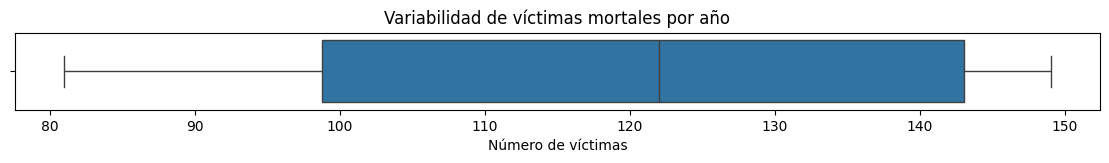

,aaaa,n_victimas
count,6.000000,6.000000
mean,2018.500000,119.166667
std,1.870829,28.701336
min,2016.000000,81.000000
25%,2017.250000,98.750000
50%,2018.500000,122.000000
75%,2019.750000,143.000000
max,2021.000000,149.000000


In [22]:
plt.figure(figsize=(14, 1)) 
sns.boxplot(data=df_period[df_period['evento_tipo']=='muerte'], x='n_victimas')
plt.title("Variabilidad de víctimas mortales por año")
plt.xlabel("Número de víctimas")
plt.show()
df_period[df_period['evento_tipo']=='muerte'].describe()

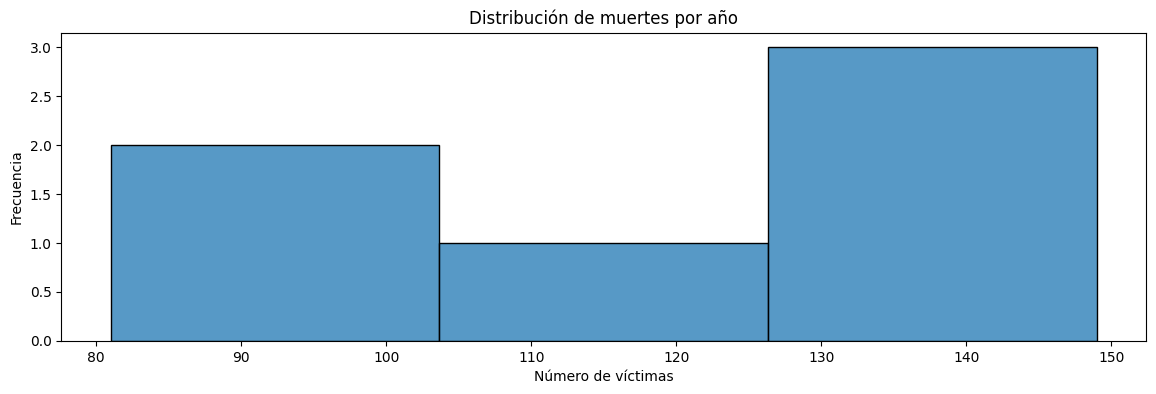

In [23]:
# Variabilidad del número de víctimas
plt.figure(figsize=(14, 4))  
sns.histplot(data=df_period[df_period['evento_tipo']=='muerte'], x='n_victimas', bins=3)
plt.title("Distribución de muertes por año")
plt.xlabel("Número de víctimas")
plt.ylabel("Frecuencia")
plt.show()

Los registros históricos muestran, para las víctimas mortales:
* Promedio anual de 119 muertes
* Desvío estándar de 28.7 muertes
* Mediana de 122 muertes
* El histograma muestra que hay una variabilidad relativamente alta, ya que casi con la misma probabilidad pueden darse 100 muertes o 140

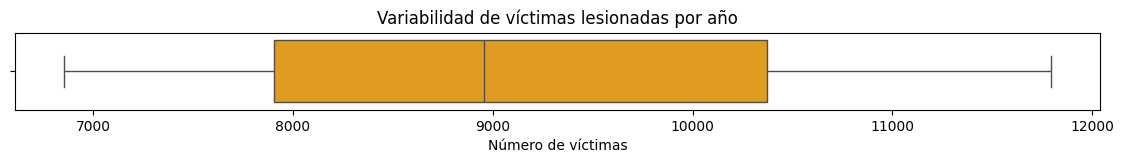

,aaaa,n_victimas
count,3.0,3.000000
mean,2020.0,9201.333333
std,1.0,2477.552489
min,2019.0,6855.000000
25%,2019.5,7906.000000
50%,2020.0,8957.000000
75%,2020.5,10374.500000
max,2021.0,11792.000000


In [24]:
plt.figure(figsize=(14, 1)) 
sns.boxplot(data=df_period[df_period['evento_tipo']=='lesión'], x='n_victimas', color = 'orange')
plt.title("Variabilidad de víctimas lesionadas por año")
plt.xlabel("Número de víctimas")
plt.show()
df_period[df_period['evento_tipo']=='lesión'].describe()

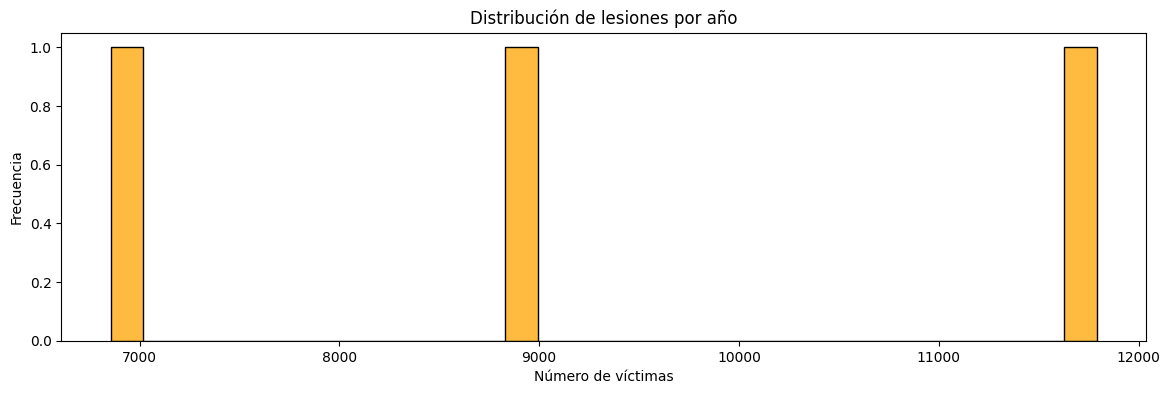

In [25]:
# Variabilidad del número de víctimas
plt.figure(figsize=(14, 4))  
sns.histplot(data=df_period[df_period['evento_tipo']=='lesión'], x='n_victimas',bins=30, color = 'orange')
plt.title("Distribución de lesiones por año")
plt.xlabel("Número de víctimas")
plt.ylabel("Frecuencia")
plt.show()

Los registros históricos muestran, para las víctimas lesionadas:
* Promedio anual de 9201 lesiones
* Desvío estándar de 2477 lesiones, lo cual es muyu alto en relación al valor promedio
* Mediana de 8957 lesiones
* El histograma muestra que hay una variabilidad grande, ya que casi con la misma probabilidad pueden darse 8000, 9000, ó 1000 lesiones en un año

## Serie de tiempo, tendencias y estacionalidad
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Serie de tiempo por período mensual

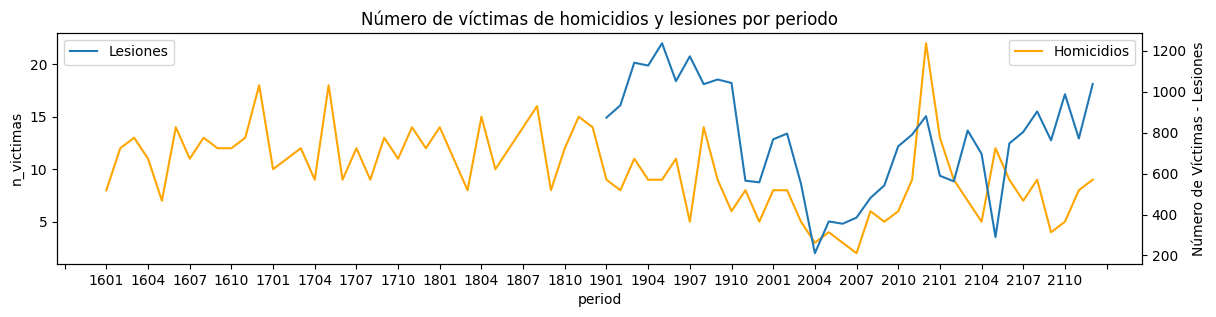

In [26]:
# Datasets que agrupan por período la cantidad de eventos ocurridos y la suma de víctimas para cada tipo de evento
dfh_period = dfh.groupby(['aaaa', 'mm', 'period', 'evento_tipo']).agg({'id':'count', 'n_victimas':'sum'}).reset_index()
dfh_period = dfh_period.rename(columns={'id':'n_eventos'})

dfl_period = dfl.groupby(['aaaa', 'mm', 'period', 'evento_tipo']).agg({'id':'count', 'n_victimas':'sum'}).reset_index()
dfl_period = dfl_period.rename(columns={'id':'n_eventos'})

plt.figure(figsize=(14, 3))
sns.lineplot(data=dfh_period, x='period', y='n_victimas', label='Homicidios', color='orange')
ax2 = plt.gca().twinx()         # Crear un segundo eje Y para las lesiones
sns.lineplot(data=dfl_period, x='period', y='n_victimas', label='Lesiones', ax=ax2)

plt.title('Número de víctimas de homicidios y lesiones por periodo')
plt.ylabel('Número de Víctimas - Homicidios')
plt.xlabel('Período (AAMM)')
ax2.set_ylabel('Número de Víctimas - Lesiones')
ax2.xaxis.set_major_locator(MultipleLocator(base=3))
plt.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.show()

El gráfico muestra la cantidad de víctimas lesionadas o mortales para cada serie de datos y para cada período o mes (indicado por el formato AAMM).
* Los eventos de lesiones muestran datos desde 2019, denotando una tendencia a disminuir, pero aumentando drásticamente hacia fines de 2010
* Los eventos de accidentes mortales muestran datos desde 2016, en donde también se observa una tendencia a la baja y un súbito aumento hacia principios de 2011
* La disminución generalizada para ambas series se dá en el contexto del covid, en lo que se aplicó una cuarentena que no permitía la libre circulación, con lo cual es lógico que se obtenga este resultado 

### Tendencias anuales

count      36.000000
mean      766.777778
std       268.385449
min       211.000000
25%       560.750000
50%       780.500000
75%       999.250000
max      1236.000000
Name: n_victimas, dtype: float64

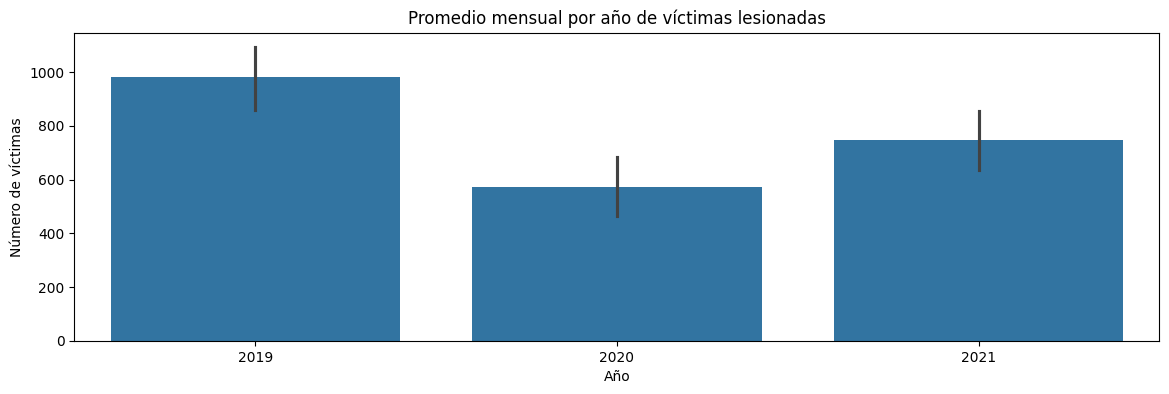

In [27]:
plt.figure(figsize=(14, 4))
sns.barplot(data=dfl_period, x='aaaa', y='n_victimas')

plt.title("Promedio mensual por año de víctimas lesionadas")
plt.xlabel('Año')
plt.ylabel('Número de víctimas')

dfl_period['n_victimas'].describe()

count    72.000000
mean      9.930556
std       3.835808
min       2.000000
25%       8.000000
50%       9.000000
75%      12.000000
max      22.000000
Name: n_victimas, dtype: float64

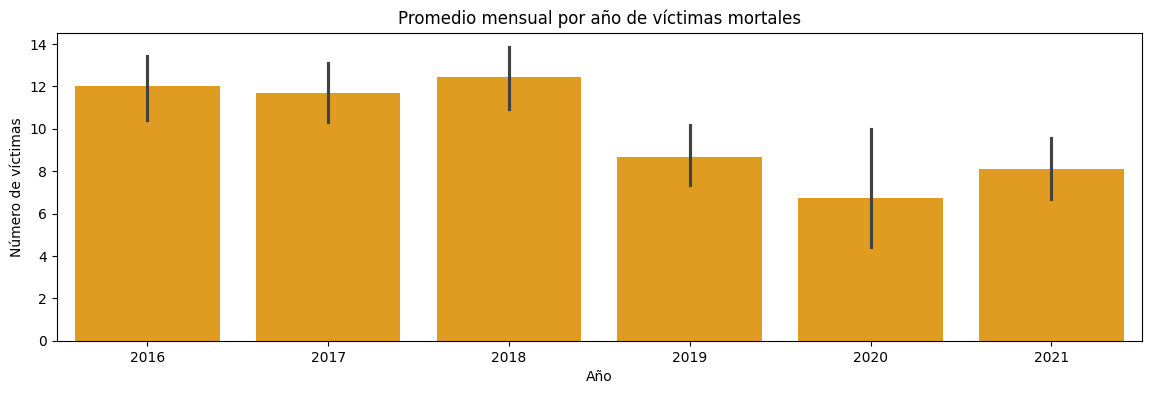

In [28]:
plt.figure(figsize=(14, 4))
sns.barplot(data=dfh_period, x='aaaa', y='n_victimas',color='orange')
plt.title("Promedio mensual por año de víctimas mortales")
plt.xlabel('Año')
plt.ylabel('Número de víctimas')

dfh_period['n_victimas'].describe()

Los últimos dos gráficos muestran para cada tipo de evento el promedio mensual de vícitimas, agrupado por año. Se puede establecer las mismas conclusiones obtenidas más arriba:
* El promedio mensual de víctimas lesionadas puede estar entre 600-800, de acuerdo a los últimos dos años
* Las víctimas lesionadas muestran una declinación en el segundo año, y un aumento en el último año
* el promedio mensual de víctimas mortales pueede estar entre 6-8, de acuerdo a los últimos tres años
* Las víctimas mortales muestran una tendencia a la baja, denotando un aumento en el año 2021

### Estacionalidad

Evaluaremos la estacionalidad mensual, por día de semana y por horario del día, pero esta vez contabilizando los eventos sin diferenciar por su consecuecnia (lesión o muerte).

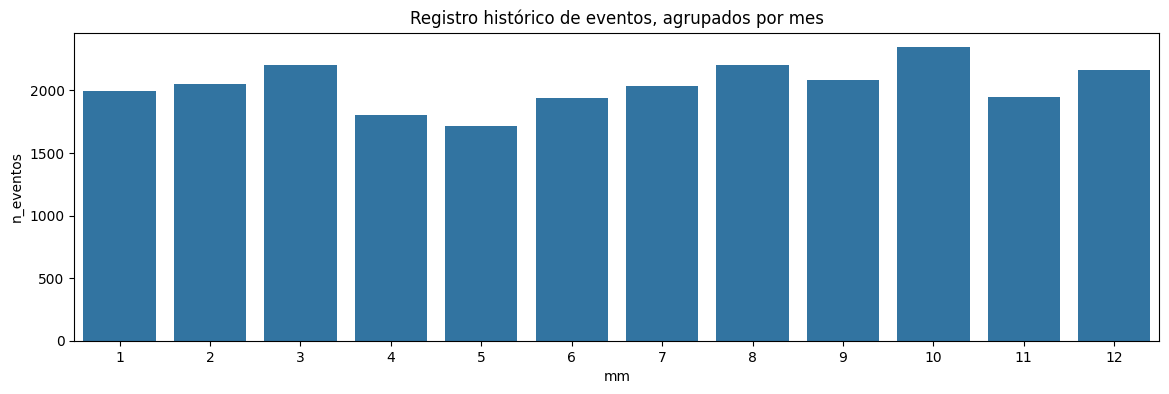

In [29]:
# Estacionalidad mensual
dfhl_month = dfhl.groupby(['mm']).agg({'id':'count', 'n_victimas':'sum'}).reset_index()
dfhl_month = dfhl_month.rename(columns={'id':'n_eventos'})

plt.figure(figsize=(14, 4))
sns.barplot(data=dfhl_month, x='mm', y='n_eventos')
plt.title("Registro histórico de eventos, agrupados por mes")

plt.show()

* La mayor cantidad de eventos se han registrado entre Octubre-Marzo
* Abril, Mayo y Junio son los meses con menor cantidad de eventos

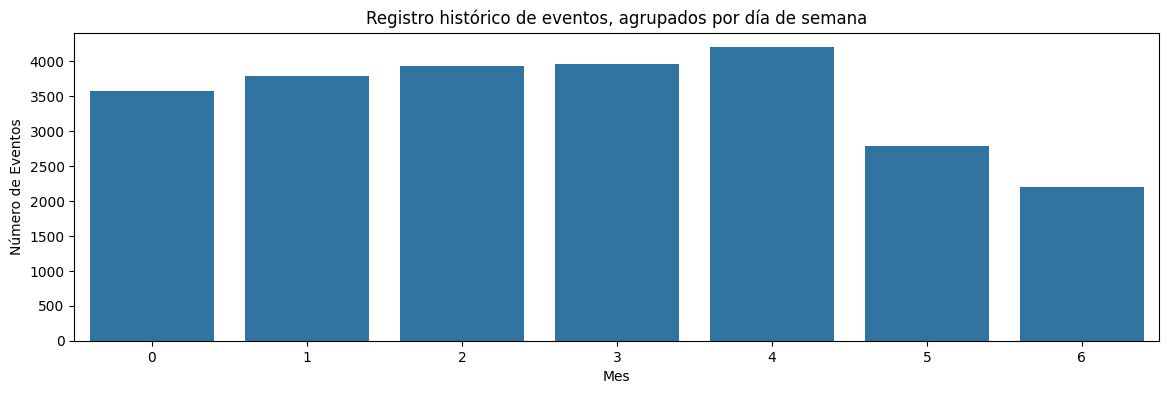

In [30]:
# Estacionalidad en el día de semana
dfhl_diasemana = dfhl.groupby(['dia_semana']).agg({'id':'count', 'n_victimas':'sum'}).reset_index()
dfhl_diasemana = dfhl_diasemana.rename(columns={'id':'n_eventos'})

plt.figure(figsize=(14, 4))
sns.barplot(data=dfhl_diasemana, x='dia_semana', y='n_eventos')
plt.title("Registro histórico de eventos, agrupados por día de semana")
plt.xlabel('Mes')
plt.ylabel('Número de Eventos')
plt.show()

* Los días de semana (días 5 y 6) son los de menor actividad
* Obsérvese la tendencia a aumentar desde los días Lunea hacia los días Viernes

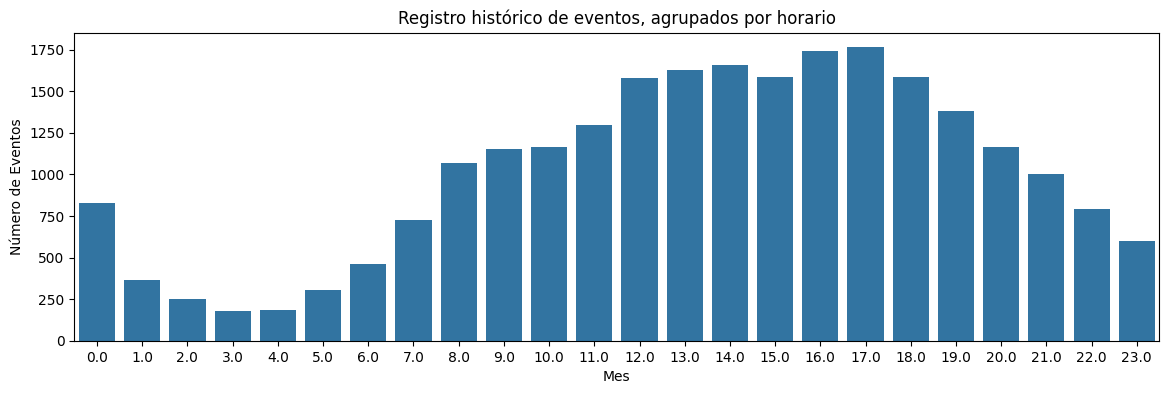

In [31]:
# Estacionalidad horaria
dfhl_horario = dfhl.groupby(['hh']).agg({'id':'count', 'n_victimas':'sum'}).reset_index()
dfhl_horario = dfhl_horario.rename(columns={'id':'n_eventos'})

plt.figure(figsize=(14, 4))
sns.barplot(data=dfhl_horario, x='hh', y='n_eventos')
plt.title("Registro histórico de eventos, agrupados por horario")
plt.xlabel('Mes')
plt.ylabel('Número de Eventos')
plt.show()

* Durante la noche se registran menos eventos, por supuesto debido a la menor circulación vehicular
* Los horarios pico se dan entre el mediodía y las 6 pm, denotando los máximos entre las 4 pm y las 5 pm

## Relación entre tipos de eventos
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

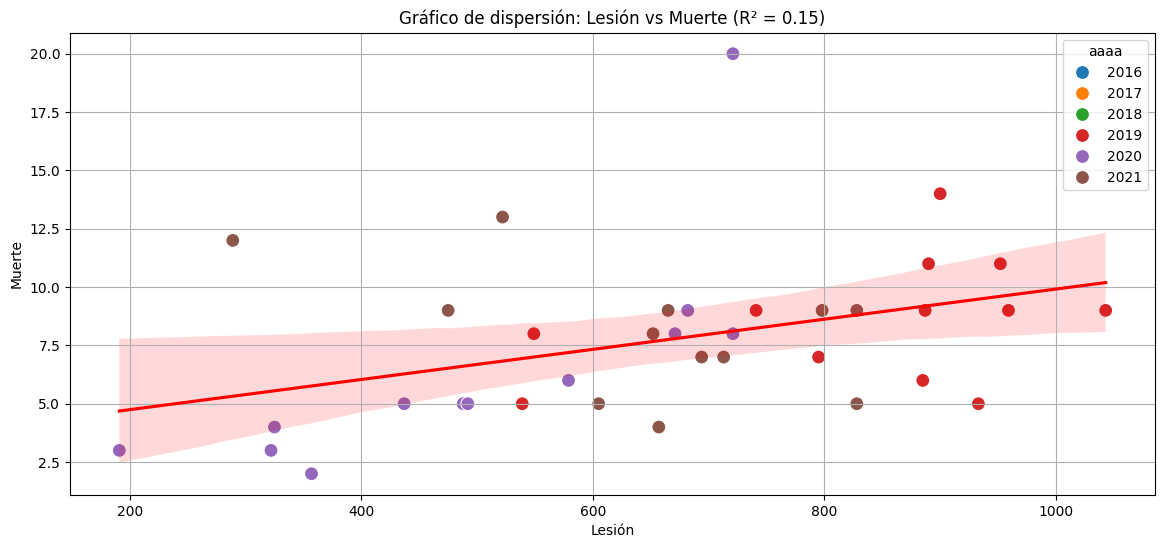

In [32]:
# Creación de dataset para contabilizar la cantidad de eventos por período
dfpivot = pd.pivot_table(dfhl,  index=['aaaa', 'period'], columns='evento_tipo', values='id', aggfunc='count', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False).reset_index()

# Creación de gráfico de dispersión
plt.figure(figsize=(14, 6))
palette = sns.color_palette("tab10", n_colors=6)
sns.scatterplot(data=dfpivot, x='lesión', y='muerte', hue='aaaa', palette=palette, s=100)  # Ajustar el tamaño de los puntos
sns.regplot(data=dfpivot, x='lesión', y='muerte', scatter=False, line_kws={"color": "red"})

correlation_matrix = dfpivot[['lesión', 'muerte']].corr()
r_squared = correlation_matrix.iloc[0, 1] ** 2

plt.title(f'Gráfico de dispersión: Lesión vs Muerte (R² = {r_squared:.2f})')
plt.xlabel('Lesión')
plt.ylabel('Muerte')
plt.grid(True)
plt.show()

El gráfico muestra la dispersión de la relación entre los eventos con lesiones y los eventos mortales, agrupados en una serie por períodos. 

* Si bien el grado de ajuste no es muy alto (15%), se nota una tendencia de correlación positiva, lo que es esperable. Es decir, habrán más muertes en tanto hayan más lesiones
* Sin embargo, al ser una correlación positiva no muy abrupta, una mayor cantidad de muertes no necesariamente es resultado de una mayor cantidad de eventos
* Tanto 2019 como 2021 son años muy dispersos, sin embargo el 2020 nuevamente muestra no sólo menores lesiones sino menor cantidad de muertes
* Un razón muy posible por la que el año 2020 muestre una disminución, es debido a la aplicación de una cuarentena civil durante el brote del covid19

## Localizaciones
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Analizaremos cuáles son las comunas con mayor cantidad de eventos registrados. Veremos sus cantidades absolutas, promedios mensuales y varaibilidad.

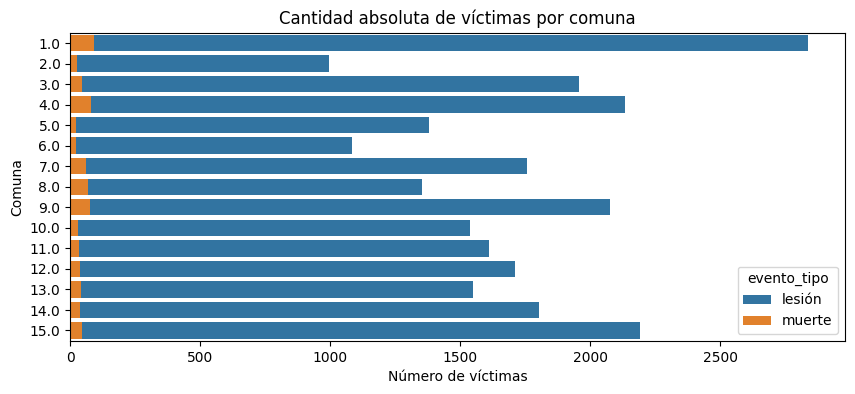

In [33]:
# Cantidad total de víctimas por comuna
df_comuna = dfhl.groupby(['comuna', 'evento_tipo'])[['n_victimas']].sum().reset_index()
df_comuna['comuna'] = df_comuna['comuna'].astype('category')

plt.figure(figsize=(10, 4)) 
sns.barplot(data=df_comuna, y='comuna', x='n_victimas', hue='evento_tipo', dodge=False)
plt.title("Cantidad absoluta de víctimas por comuna")
plt.xlabel("Número de víctimas")
plt.ylabel("Comuna")
plt.show()

El gráfico muestra la cantidad total registrada de eventos diferenciados por lesión o muerte, agrupados por comuna.
* La comuna nro 1 es la que más casos registra
* Le siguen las comunas 15, 9, y 4
* Las comunas 2 y 6 son las de menor actividad
* Resulta condescendiente que las comunas con mayor cantidad de eventos, también presenten 

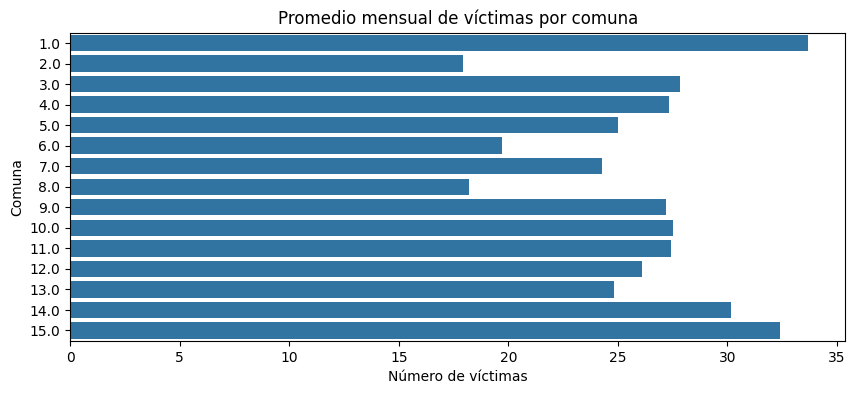

In [34]:
# Promedio mensual de víctimas por comuna
df_period_comuna = dfhl.groupby(['aaaa', 'period', 'comuna', 'evento_tipo'])[['n_victimas']].sum().reset_index()
df_period_comuna = df_period_comuna.sort_values(by='n_victimas', ascending=True)
df_period_comuna['comuna'] = df_period_comuna['comuna'].astype('category')
df_period_comuna

plt.figure(figsize=(10, 4)) 
sns.barplot(data=df_period_comuna, y='comuna', x='n_victimas', errorbar=None)
plt.title("Promedio mensual de víctimas por comuna")
plt.xlabel("Número de víctimas")
plt.ylabel("Comuna")
plt.show()

Los promedios mensuales por comunas no necesariamente dan la misma información que las cantidades absolutas.
* Las comunas con mayores promedios mensuales son 1, 15 y 14
* Cuando una comuna tiene un promedio menor que otra, significa que a lo largo del tiempo, su cantidad de eventos ha disminuido, lo que concluye en una mejora del indicador. Ejemplo:
    * La comuna 9 tiene un valor total mayor a la comuna 14
    * La comuna 9 tiene un promedio mensual menor que la comuna 14
    * Significa que la comnuna 9 ha mejorado a lo largo del tiempo con respecto a la comuna 14

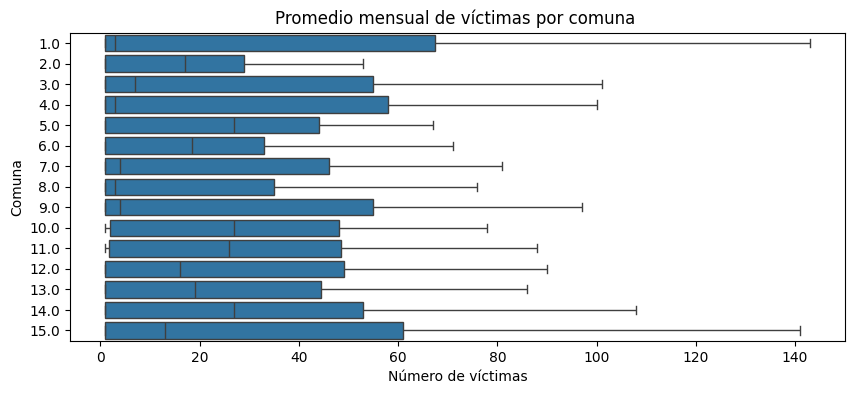

In [35]:
# Variabilidad del promedio mensual de víctimas por comuna
plt.figure(figsize=(10, 4))  
sns.boxplot(data=df_period_comuna, y='comuna', x='n_victimas')
plt.title("Promedio mensual de víctimas por comuna ")
plt.xlabel("Número de víctimas")
plt.ylabel("Comuna")
plt.show()

Los boxplot permiten visualizar parte del comportamiento variable de cada comuna, exponiendo mmínimos, máximos y mediana, principalmente.
* Las comunas 1, 15 y 4 presentan la mayor variabilidad
* No se observan valores similares de mediana entre comunas, lo que indica también la alta ariabilidad entre ellas. Es decir, no se ven patrones de comportamiento similares entre comunas

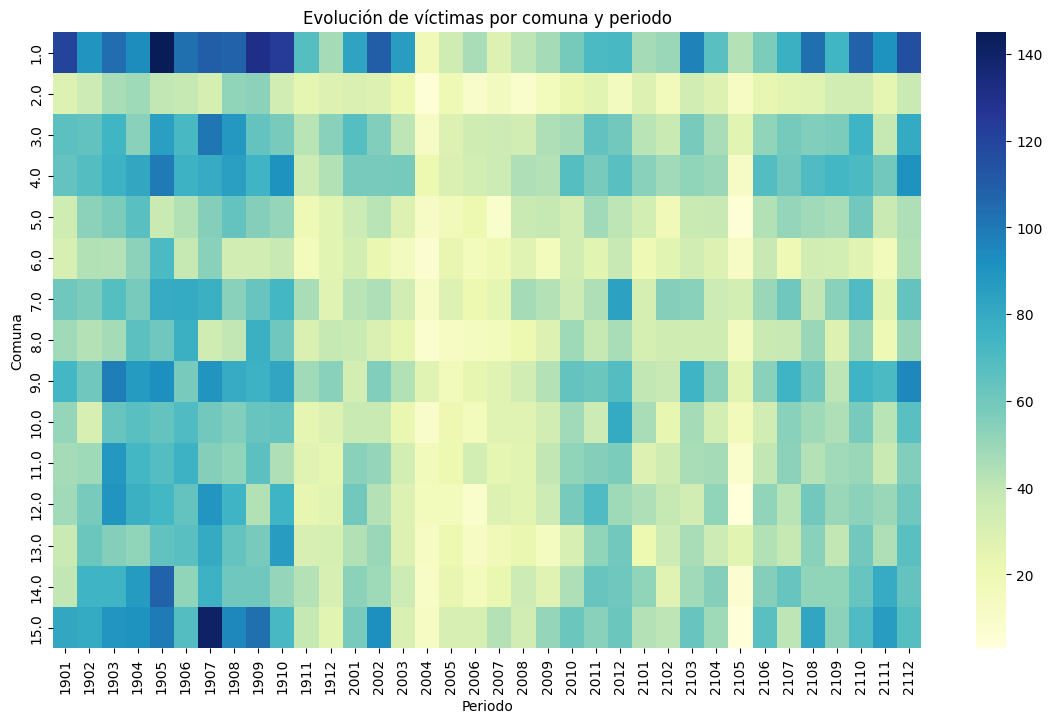

In [36]:
heat_pivot = df_period_comuna[df_period_comuna['aaaa'] >= 2019]
heat_pivot = heat_pivot.pivot_table(index='comuna', columns='period', values='n_victimas', aggfunc='sum')

plt.figure(figsize=(14, 8))
sns.heatmap(heat_pivot, cmap='YlGnBu')
plt.title('Evolución de víctimas por comuna y periodo')
plt.xlabel('Periodo')
plt.ylabel('Comuna')
plt.show()


El mapa de calor permite la evolución de la cantidad de víctimas registradas por comuna y por período, en eswta caso filtrando desde 2019.
* Entre Abr 2020 - Sep 2020 se observan pocos casos en todas las comunas. En particular, esto ha sucedido debido a la cuarentena del covid
* Las comunas 1 y 15 son las que históricamente más casos registran, pero la diferencia es que la comuna 15 ha ido disminuyendo sus víctimas

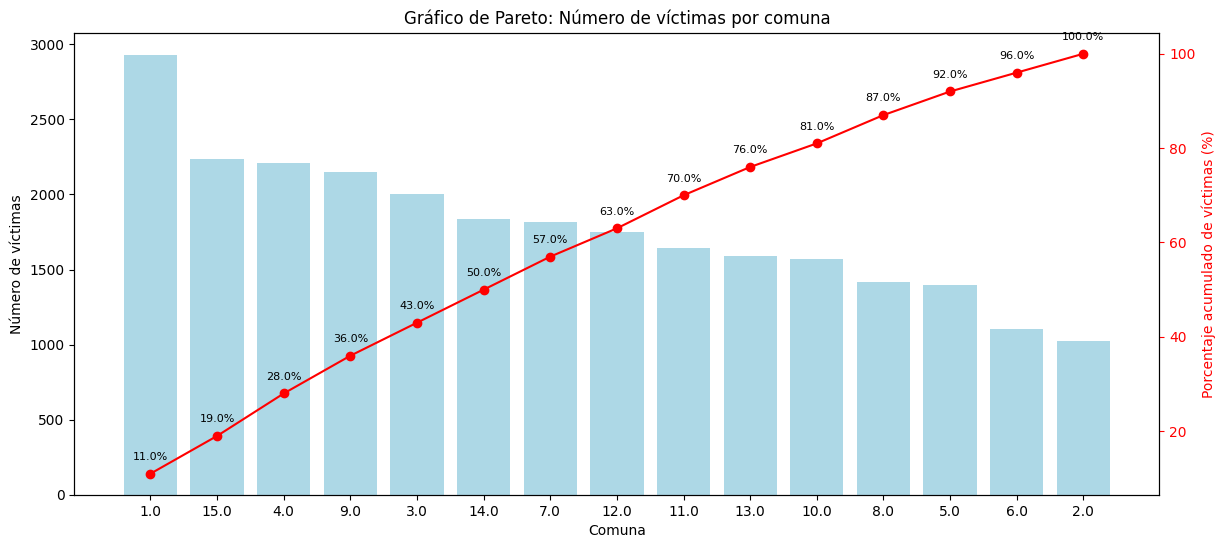

In [37]:
# Gráfico de Pareto
comunas_pareto = dfhl.groupby('comuna')['n_victimas'].sum().reset_index()
comunas_pareto = comunas_pareto.sort_values(by='n_victimas', ascending=False)
comunas_pareto['cum_victimas'] = comunas_pareto['n_victimas'].cumsum()
comunas_pareto['cumperc_victimas'] = (comunas_pareto['n_victimas'].cumsum() / comunas_pareto['n_victimas'].sum()).round(2) * 100

comunas_pareto['comuna'] = comunas_pareto['comuna'].astype(str) # Convertir el campo 'comuna' en una variable categórica
comunas_pareto = comunas_pareto.sort_values(by='n_victimas', ascending=False)

# Gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.bar(comunas_pareto['comuna'], comunas_pareto['n_victimas'], color='lightblue')
ax1.set_xlabel('Comuna')
ax1.set_ylabel('Número de víctimas')
ax1.tick_params('y')


ax2 = ax1.twinx() # Eje Y secundario (porcentaje acumulado de víctimas)
ax2.plot(comunas_pareto['comuna'], comunas_pareto['cumperc_victimas'], color='r', marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje acumulado de víctimas (%)', color='r')
ax2.tick_params('y', colors='r')

for i, perc in enumerate(comunas_pareto['cumperc_victimas']):
    ax2.annotate(f'{perc:.1f}%', (comunas_pareto['comuna'].iloc[i], perc), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
plt.title('Gráfico de Pareto: Número de víctimas por comuna')
plt.show()


El gráfico de Pareto es muy útil pues nos permite visualizar no sólo las comunas con mayor actividad, sino también brindarles un peso relativo a la cantidad total de eventos registrados. 

Este gráfico muestra el total de víctimas ya sea por lesión o mortales, agrupado por comuna y ordenado en forma descendente según la suma de víctimas de cada comuna. En este caso no se cumple la regla del 80/20, pero aún así se puede determinar el peso relevante para cada comuna, lo que resulta útil a la hora de aplicar prioridades en las mejoras de infraestructura vehicular.
* Del total de 15 comunas, las 2 primeras toman aproximadamente el 20% de los eventos
* Del total de 15 comunas, las 6 primeras toman aproximadamente el 50% de los eventos
* Del total de 15 comunas, las 11 primeras toman aproximadamente el 80% de los eventos

## Tipos de víctimas
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Veremos en mayor detalle la relación acusado-víctima de los eventos, en función de conocer cuáles son los participantes que mayormente causan los accidentes, así como conocer cuáles son las víctimas que mayor aparecen.

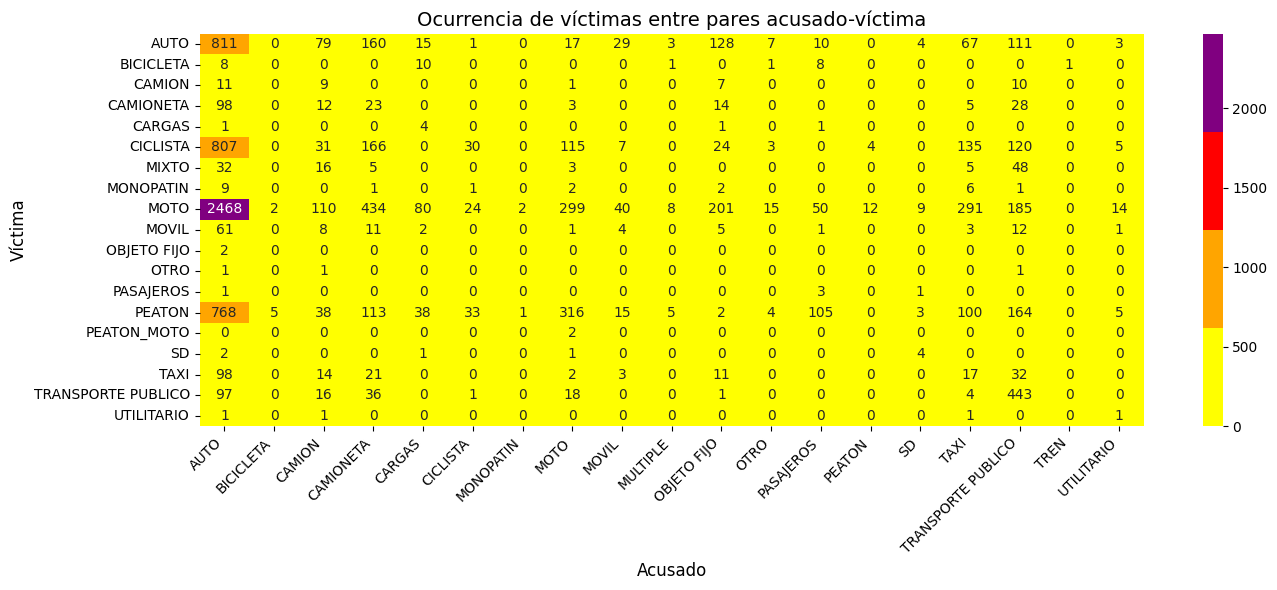

In [38]:
# Dataset acusado-victima
df_av = dfhl[['acusado', 'victima', 'evento_tipo', 'n_victimas']]
pivot_av = df_av.pivot_table(index='victima', columns='acusado', values='n_victimas', aggfunc='sum', fill_value=0)

colors = ["yellow", "orange", "red", "purple"]
n_colors = len(colors)
color_map = LinearSegmentedColormap.from_list("custom", colors, N=n_colors)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_av, cmap=color_map, annot=True, fmt='d')

plt.title('Ocurrencia de víctimas entre pares acusado-víctima', fontsize=14)
plt.xlabel('Acusado', fontsize=12)
plt.ylabel('Víctima', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

El mapa de calor permite conocer cuáles son los pares acusado-víctima con mayor interacción. Esto permite conocer hacia quiénes deben estar dirigidos los planes de educación vial y mejora de infraestructura vial.
* Los AUTOS son los mayores causantes de eventos, seguidos de TRANPORTE PUBLICO
* Las principales víctimas son las MOTOS, seguidos de CICILSTAS, PEATONES y otros AUTOS

In [39]:
df_sun = dfhl.groupby(['acusado', 'victima'])['n_victimas'].sum().reset_index()
fig = px.sunburst(df_sun, path=['acusado', 'victima'], values='n_victimas', 
                  hover_data=['n_victimas'],  # Mostrar valores al pasar el mouse
                  title='Gráfico Sunburst con Valores de n_victimas')

fig.update_layout(width=800, height=600)
fig.show()

El gráfico tipo sunburst permite visualizar en forma interactiva la misma información provista por el heatmap, pero viendo las proporciones en formato de torta.
* El anillo primario muestra los acusados
* El anillo secundario muestra las víctimas
* Los principales acusados (causantes) son los autos, transporte público, camioneta y motos, lo cual se condice con el heatmap
* Cualquiera de los acusados tiene una gran interacción con la moto como víctima, lo que también se condice con el heatmap

# Conclusiones
================================================================================================================================================================================

Los registros históricos muestran, para toda la ciudad:
* Un promedio de 120 víctimas mortales por año
* Un promedio de 9200 víctimas lesionadas por año

Las series de tiempo muestran:
* Un promedio mensual de 10 víctimas mortales
* Un promedio mensual de 767 víctimas lesionadas
* En el año 2020 se registran abruptamente menos eventos, debido a la cuarentena del covid19
* Hay una tendencia a la baja en los últimos años, muy posiblemente vinculada al item anterior pues los datos están entre 2016-2021
* En cuanto a las estacionalidades:
    * Entre Octubre-Marzo se registran la mayor cantidad de eventos
    * Los fines de semana tienen menos actividad
    * El horario pico de accidentes se dá entre las 4 pm y 5 pm

El análisis entre tipos de eventos permite ver:
* Las lesiones y muertes tienen cierta correlatividad levemente positiva, lo cual es esperable
* Una gran cantidad de lesiones no necesariamente conlleva a un número alto de muertes

Del análisis geográfico, podemos determinar:
* Las comunas 1, 15 y 14 tienen los mayores promedios mensuales
* Las comunas 1, 15 y 4 tienen las mayores variabilidades
* Todas las comunas presentan una baja en el año 2020, lo cual indica que la aplicación de cuarentena fué global
* Las comunas 1 y 15 registran la mayor actividad de eventos, pero la comuna 15 ha ido disminuyendo sus accidentes
* El 50% de los eventos ocurren en sólo 6 comunas: la 1, 15, 4, 9, 3 y 14

El análisis de víctimas nos permite concluir en lo siguiente:
* Los autos son los principales causantes de accidentes
* Las motos son las principales víctimas
* Hay un total de 2468 (el 25% de los eventos) correspondientes al par auto-moto, en donde el accidente es ocasionado por el auto y la víctima es la moto